# 이미지 변환
- ocr 파일 내 bbox 3D 변환 및 크롭 저장
- pkl 파일 내 bbox 칼럼에 있는 bbox만 활용

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os


# BBox 크기 계산(크롭할 이미지 크기 계산)
def calculate_bbox_size(bbox):
    bbox = np.array(bbox, dtype=np.float32)  # 리스트를 numpy 배열로 변환
    width1 = np.linalg.norm(bbox[0] - bbox[1])  # 위쪽 변의 길이
    width2 = np.linalg.norm(bbox[2] - bbox[3])  # 아래쪽 변의 길이
    height1 = np.linalg.norm(bbox[0] - bbox[3]) # 왼쪽 변의 길이
    height2 = np.linalg.norm(bbox[1] - bbox[2]) # 오른쪽 변의 길이
    
    # 가로와 세로 길이의 최대치 계산
    width = int(max(width1, width2))
    height = int(max(height1, height2))
    
    return width, height

# 이미지와 BBox를 처리하는 함수(이미지 크롭 및 평면 맞추기)
def process_image(img_path, bboxes, text_list, save_dir=None):
    img = cv2.imread(img_path)
    if img is None:
        print(f"이미지를 로드할 수 없습니다: {img_path}")
        return
    
    cropped_images = []
    
    for idx, bbox in enumerate(bboxes):
        bbox = np.array(bbox, dtype=np.float32)  # 좌표를 numpy 배열로 변환
        x_pos, y_pos = calculate_bbox_size(bbox)
        warped_coord = np.float32([[0, 0], [x_pos, 0], [x_pos, y_pos], [0, y_pos]])
        # 이미지 변환 - 평면 맞추기
        mat = cv2.getPerspectiveTransform(bbox, warped_coord)
        warped_img = cv2.warpPerspective(img, mat, (x_pos, y_pos), flags=cv2.INTER_CUBIC)
        # 이미지 리스트에 저장
        cropped_images.append(warped_img)
        
        #파일 저장
        if save_dir:
            save_path = os.path.join(save_dir, f'{os.path.splitext(os.path.basename(img_path))[0]}_crop_{idx}.png')
            cv2.imwrite(save_path, warped_img)
    
    return cropped_images

# 데이터프레임 로드 (pkl 파일)
df = pd.read_pickle('df_json+ocr_sample100.pkl')


# pkl 파일 데이터를 통한 bbox 및 이미지 처리 메인
for index, row in df.iterrows():
    img_name = row['id']
    img_path = row['image']
    bboxes = row['bbox']
    texts_list = row['text']
    
    # 출력 디렉토리 설정
    save_dir = 'data/cropped_images'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # 이미지 처리 및 저장
    cropped_images = process_image(img_path, bboxes, save_dir)

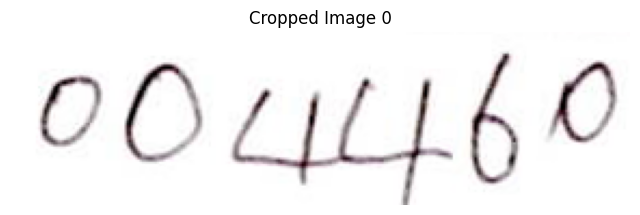

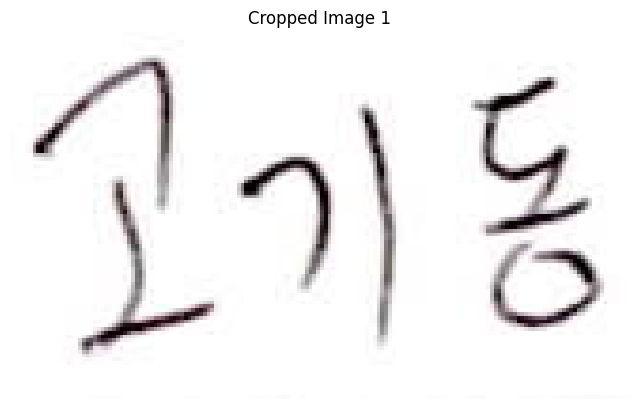

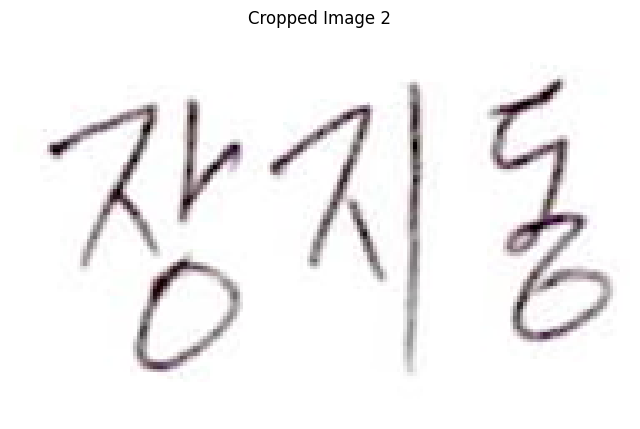

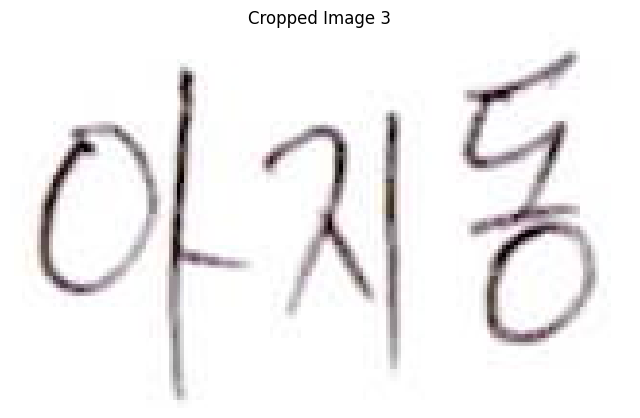

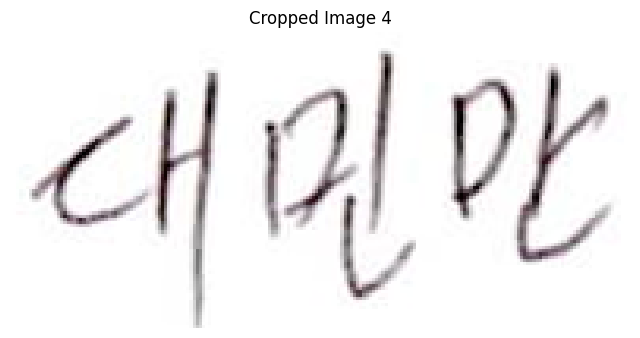

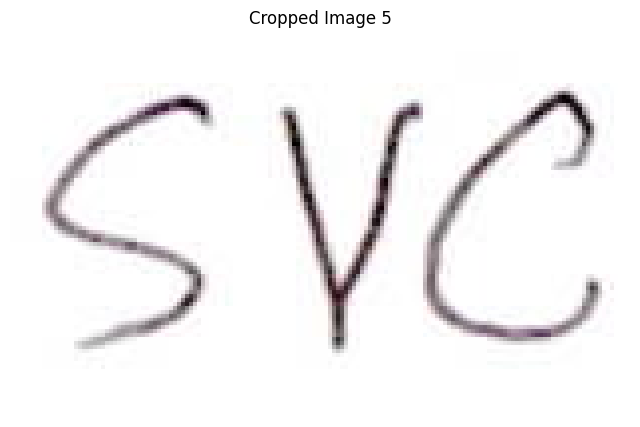

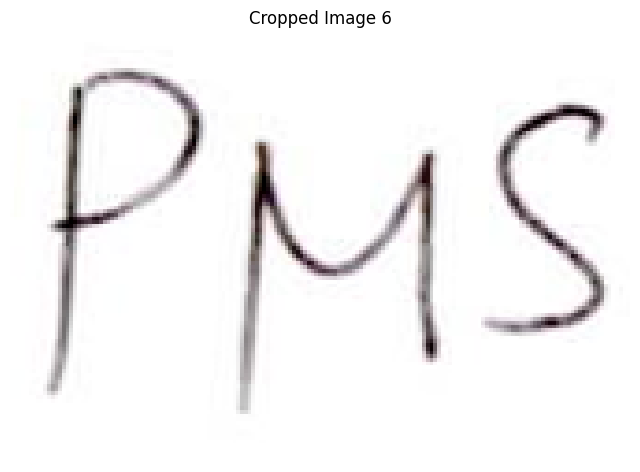

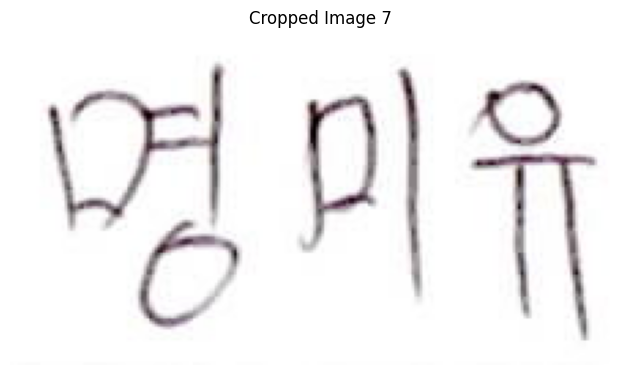

In [ ]:
# cropped image 비틀기 확인 용도
for i, cropped_img in enumerate(cropped_images):
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Cropped Image {i}')
    plt.axis('off')
    plt.show()